## Problem Set #3
### MACS 30100, Dr. Evans

### Name: Xiang Zhang
### snzhang@uchicago.edu

### Problem One: Some income data, lognormal distribution, and GMM

In [56]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 = matplotlib.cm.get_cmap('summer')

wages = np.loadtxt('incomes.txt')

#### (a) Histogram

Below I plot a histogram with 30 bins to show the income distribution

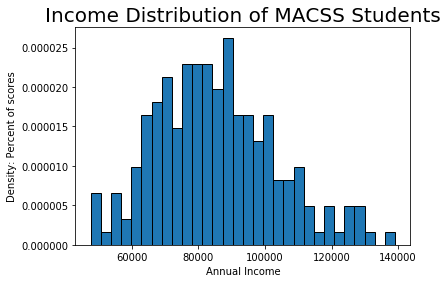

In [57]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title('Income Distribution of MACSS Students', fontsize=20)
plt.xlabel('Annual Income')
plt.ylabel('Density: Percent of scores')
plt.show()

#### (b) GMM Estimates

I first define the function computing log normal distribution

In [58]:
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the log normal pdf with mean mu and
    standard deviation sigma. 
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the log normally distributed random variable
    sigma  = scalar > 0, standard deviation of the log normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:

    pdf_vals = (N,) vector, log normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
            
    pdf_vals    = (1/(xvals * sigma * np.sqrt(2 * np.pi) ) *
                   np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    
    return pdf_vals

Then I define the function computing the data moments

In [59]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    sd_data = np.sqrt(xvals.var())
    
    return mean_data, sd_data

Then I define the function generating model moments

In [60]:
def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    
    mean_model = np.exp(mu + sigma ** 2 / 2)
    var_model = np.exp(2 * mu + sigma ** 2) * (np.exp(sigma ** 2) - 1)
    
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

Then the function defining moment error

In [61]:
def err_vec(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])

    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

And fianlly, the criterion function

In [62]:
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

Now I start to implement GMM estimation

In [63]:
mean_data, std_data = data_moments(wages)
mu_init = np.log(mean_data / np.sqrt(1 + std_data ** 2 / mean_data ** 2))
sigma_init = np.log(1 + + std_data ** 2 / mean_data ** 2)

params_init = np.array([mu_init, sigma_init])

W_hat = np.eye(2)
gmm_args = (wages, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

mu_GMM_ident_mat, sig_GMM_ident_mat = results.x
print('mu_GMM1=',mu_GMM_ident_mat, ' sig_GMM1=', sig_GMM_ident_mat)
print(results)

mu_GMM1= 11.3318833907  sig_GMM1= 0.208696169441
      fun: array([[  5.97510202e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.97656516e-06,   1.62958736e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 11
   status: 0
  success: True
        x: array([ 11.33188339,   0.20869617])


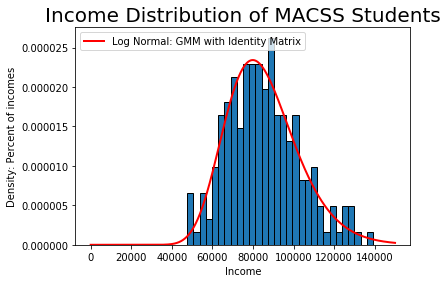

In [64]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title("Income Distribution of MACSS Students", fontsize = 20)
plt.ylabel("Density: Percent of incomes")
plt.xlabel("Income")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='Log Normal: GMM with Identity Matrix')
plt.legend(loc='upper left')

plt.show()

In [83]:
print("GMM criterion function at the estimated parameter values is", results.fun[0])
print("Two data moments are", data_moments(wages))
print("Two model moments are", model_moments(mu_GMM_ident_mat, sig_GMM_ident_mat))
print("Error vector", err_vec(wages, mu_GMM_ident_mat, sig_GMM_ident_mat))

GMM criterion function at the estimated parameter values is [ -7.09510673e-07]
Two data moments are (85276.823606258113, 17992.542128046523)
Two model moments are (85277.032036812874, 17992.542741812224)
Error vector [[  2.44416415e-06]
 [  3.41122280e-08]]


#### (c) Two-step GMM
The code below performs a two-step GMM estimation

In [82]:
err_firststep = err_vec(wages, mu_GMM_ident_mat, sig_GMM_ident_mat)
print(len(wages), wages.shape)
VCV_2step = np.dot(err_firststep, err_firststep.T) / len(wages)
print("Variance-covariance matrix is \n", VCV_2step)

W_hat_2step = lin.pinv(VCV_2step)  
print("W_hat is \n", W_hat_2step)

200 (200,)
Variance-covariance matrix is 
 [[  2.98696919e-14   4.16879424e-16]
 [  4.16879424e-16   5.81822051e-18]]
W_hat is 
 [[  3.34657132e+13   4.67067664e+11]
 [  4.67067664e+11   6.51867785e+09]]


In [76]:
mean_data, std_data = data_moments(wages)
mu_init = np.log(mean_data / np.sqrt(1 + std_data ** 2 / mean_data ** 2))
sigma_init = np.log(1 + + std_data ** 2 / mean_data ** 2)

params_init = np.array([mu_init, sigma_init])

W_hat = W_hat_2step
gmm_args = (wages, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

mu_GMM_2step, sig_GMM_2step = results.x
print('mu_GMM1=',mu_GMM_2step, ' sig_GMM1=', sig_GMM_2step)
print(results)

mu_GMM1= 11.363307605  sig_GMM1= 0.04700121268
      fun: array([[ -7.09510673e-07]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 345025.9853012 ,    4591.37175293])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 309
      nit: 8
   status: 2
  success: False
        x: array([ 11.3633076 ,   0.04700121])


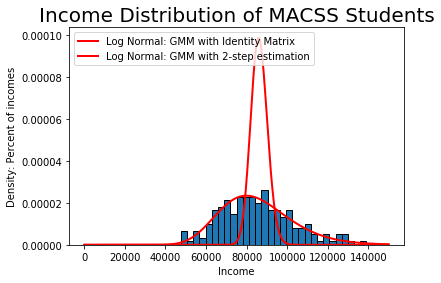

In [77]:
count, bins, patches = plt.hist(wages, 30, edgecolor='black', normed=True)
plt.title("Income Distribution of MACSS Students", fontsize = 20)
plt.ylabel("Density: Percent of incomes")
plt.xlabel("Income")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='Log Normal: GMM with Identity Matrix')
plt.legend(loc='upper left')

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_2step, sig_GMM_2step),
         linewidth=2, color='r', label='Log Normal: GMM with 2-step estimation')
plt.legend(loc='upper left')

plt.show()